<a href="https://colab.research.google.com/github/chumdan/Machine-Learning-Project/blob/main/Machine%20Learning%20Project/Time%20series/%EB%AC%B8%EC%A0%9C11_%EB%B9%84%ED%8A%B8%EC%BD%94%EC%9D%B8%EA%B0%80%EA%B2%A9%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제 : 비트코인 가격예측(시계열문제유형)

### Step 0. 필요패키지 설치

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
from scipy import stats

##  Evaluation metrics

# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# keras 시계열 딥러닝 관련
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

In [ ]:
### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

In [ ]:
# Google colab: 데이터 경로 설정
path = '/content/drive/MyDrive/Colab Notebooks/practice/시계열문제/data/Cryptocurrency/Bitcoin.csv'
raw_all = pd.read_csv(path, index_col='Date')
# 인덱스가 문자로 되어 있기 때문에, 날짜 형식으로 바꿔준다.
raw_all.index = pd.to_datetime(raw_all.index)

In [ ]:
raw_all

,BTC-USD
Date,
2017-01-01,998.33
2017-01-02,"1,021.75"
2017-01-03,"1,043.84"
2017-01-04,"1,154.73"
2017-01-05,"1,013.38"
...,...
2020-10-27,"13,654.22"
2020-10-28,"13,271.29"
2020-10-29,"13,437.88"


### Step1. 기초통계량 및 시각화

In [ ]:
raw_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1400 entries, 2017-01-01 to 2020-10-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BTC-USD  1400 non-null   float64
dtypes: float64(1)
memory usage: 21.9 KB


In [ ]:
raw_all.describe()

,BTC-USD
count,"1,400.00"
mean,"7,009.43"
std,"3,479.08"
min,777.76
25%,"4,045.50"
50%,"7,247.58"
75%,"9,388.31"
max,"19,497.40"


(0.0, 21447.140429)

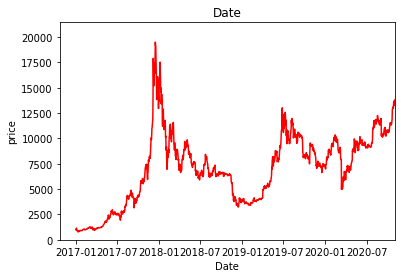

In [ ]:
  plt.plot(raw_all.index, raw_all['BTC-USD'], 'r-')
  plt.ylabel('price')
  plt.title('Date')
  plt.xlabel('Date')
  plt.xlim(right=raw_all.index[-1]) # x리미트를 설정
  plt.ylim(0,  raw_all['BTC-USD'].max()*1.1)

### Step 2. 딥러닝 시계열 분석(MLP, RNN, LTSM, GRU 분석)

#### MLP 분석

In [ ]:
# Parameters
criteria = '2020-01-01'
scaler = preprocessing.MinMaxScaler()
sequence = 60
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0


# Train & Test Split
train = raw_all.loc[raw_all.index < criteria,:]
test = raw_all.loc[raw_all.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)



Train_size: (1095, 1) Test_size: (305, 1)


In [ ]:
# Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

# Retype and Reshape(list를 array로 바꿔줌.)
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

X_train: (1035, 60, 1) Y_train: (1035, 1)
X_test: (245, 60, 1) Y_test: (245, 1)


In [ ]:
# MLP
# 3차원 2차원 변환_reshape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
print('Reshaping for MLP')
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

Reshaping for MLP
X_train: (1035, 60) Y_train: (1035, 1)
X_test: (245, 60) Y_test: (245, 1)


In [ ]:
# MLP 모델링
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(dropout_ratio)) 

model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_ratio)) 

model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_ratio)) 

model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_ratio)) 

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               7808      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

In [ ]:
# 학습
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

Epoch 1/10
33/33 [==============================] - 3s 2ms/step - loss: 0.0367
Epoch 2/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 3/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 4/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 5/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6/10
33/33 [==============================] - 0s 2ms/step - loss: 7.7513e-04
Epoch 7/10
33/33 [==============================] - 0s 2ms/step - loss: 8.2614e-04
Epoch 8/10
33/33 [==============================] - 0s 2ms/step - loss: 6.8627e-04
Epoch 9/10
33/33 [==============================] - 0s 2ms/step - loss: 7.8715e-04
Epoch 10/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0012


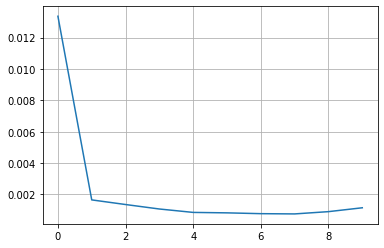

In [ ]:
plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

8/8 [==============================] - 0s 2ms/step - loss: 0.0000e+00


,MAE,MSE,MAPE
Train,321.68,"238,428.97",4.87
Test,504.91,"388,918.89",5.49


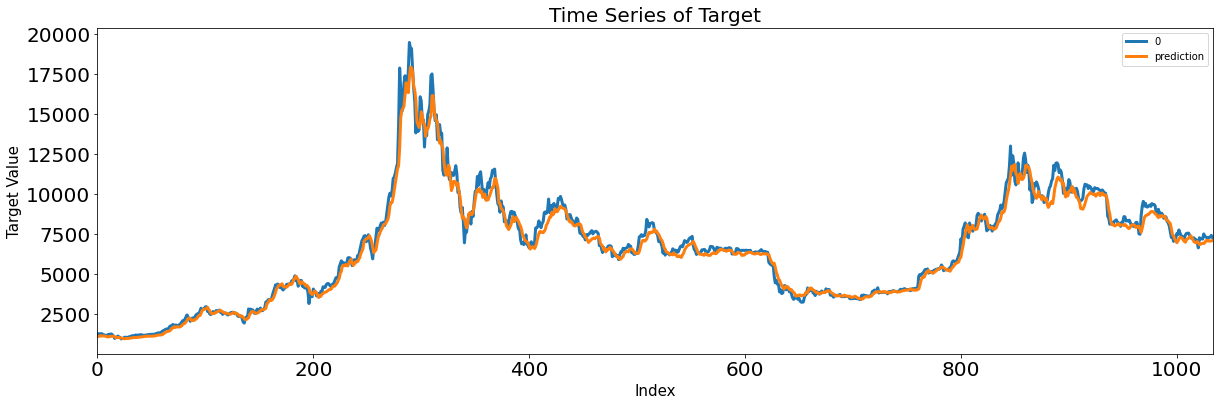

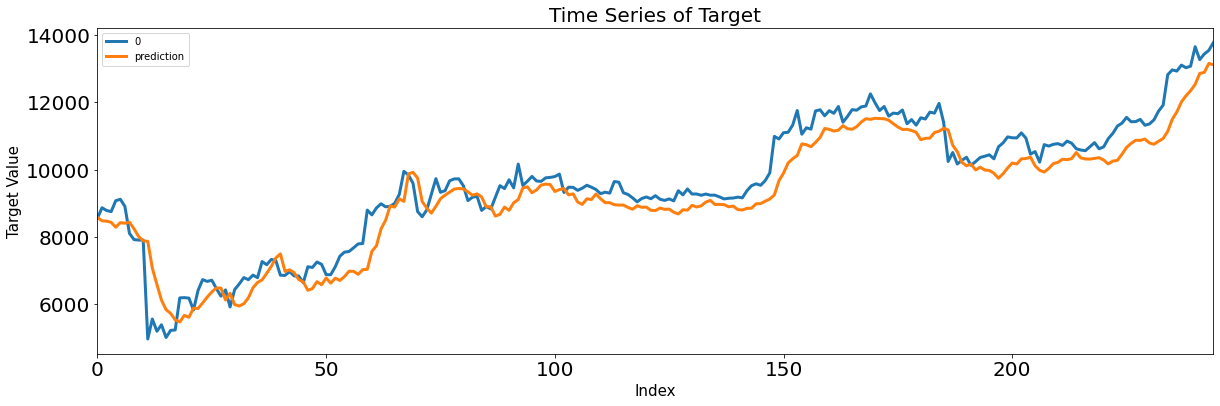

In [ ]:
# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)
# evaluation
result = model.evaluate(X_test, Y_test_pred)
# 스케일 변환_ inverse_transform
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_MLP, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_MLP)

#### RNN 분석

In [ ]:
# Parameters
criteria = '2020-01-01'
scaler = preprocessing.MinMaxScaler()
sequence = 60
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0


# Train & Test Split
train = raw_all.loc[raw_all.index < criteria,:]
test = raw_all.loc[raw_all.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)


Train_size: (1095, 1) Test_size: (305, 1)


In [ ]:
## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

X_train: (1035, 60, 1) Y_train: (1035, 1)
X_test: (245, 60, 1) Y_test: (245, 1)


In [ ]:
# RNN 모델링
# 시간차원 고려를 위해, 초기 차원은 시간차원까지 반영
model = Sequential()

model.add(SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 

model.add(SimpleRNN(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 

model.add(SimpleRNN(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 

model.add(SimpleRNN(64, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Flatten())

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 60, 128)           16640     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 60, 256)           98560     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 60, 128)           49280     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 60, 64)           

In [ ]:
# 학습
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

Epoch 1/10
33/33 [==============================] - 6s 137ms/step - loss: 0.0223
Epoch 2/10
33/33 [==============================] - 4s 134ms/step - loss: 0.0048
Epoch 3/10
33/33 [==============================] - 4s 135ms/step - loss: 0.0019
Epoch 4/10
33/33 [==============================] - 4s 136ms/step - loss: 0.0019
Epoch 5/10
33/33 [==============================] - 5s 138ms/step - loss: 0.0014
Epoch 6/10
33/33 [==============================] - 5s 137ms/step - loss: 0.0015
Epoch 7/10
33/33 [==============================] - 4s 135ms/step - loss: 9.0508e-04
Epoch 8/10
33/33 [==============================] - 4s 131ms/step - loss: 0.0025
Epoch 9/10
33/33 [==============================] - 4s 135ms/step - loss: 0.0012
Epoch 10/10
33/33 [==============================] - 5s 142ms/step - loss: 9.0011e-04


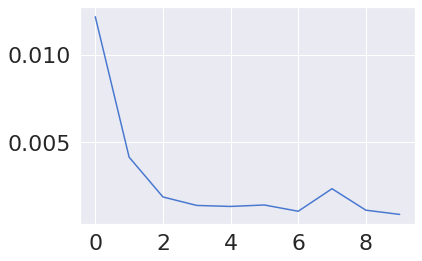

In [ ]:
plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

8/8 [==============================] - 0s 15ms/step - loss: 0.0000e+00


,MAE,MSE,MAPE
Train,414.00,"398,451.86",5.96
Test,670.83,"569,204.24",7.06


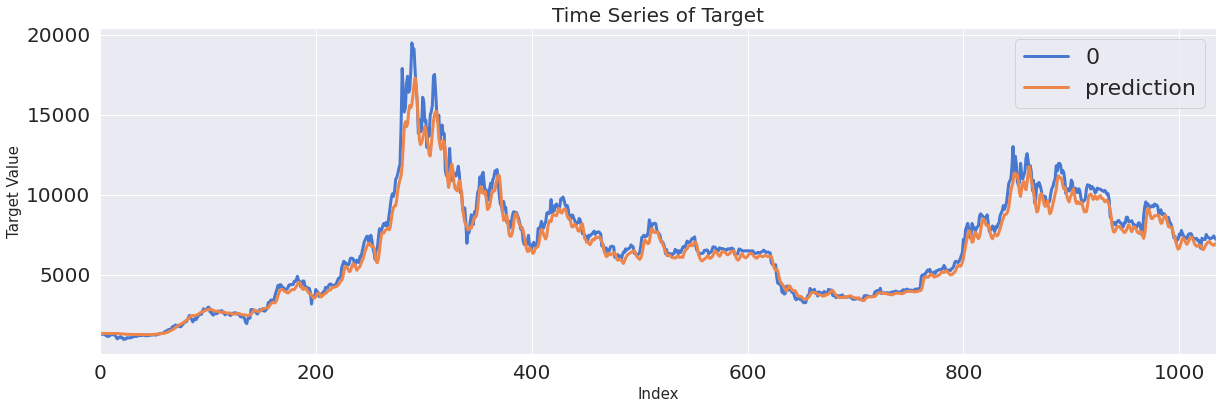

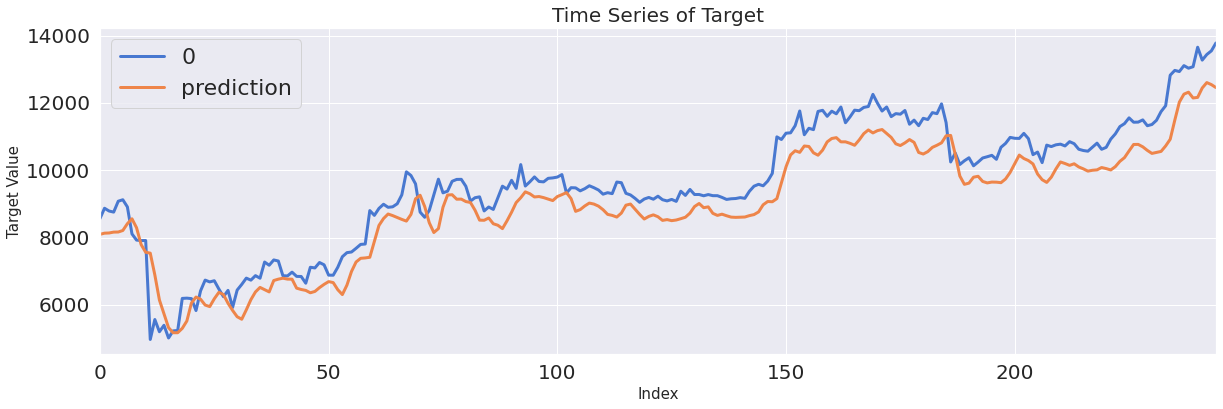

In [ ]:
# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_RNN, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_RNN)


#### LSTM 분석

In [ ]:
# Parameters
criteria = '2020-01-01'
scaler = preprocessing.MinMaxScaler()
sequence = 60
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = raw_all.loc[raw_all.index < criteria,:]
test = raw_all.loc[raw_all.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)

Train_size: (1095, 1) Test_size: (305, 1)


In [ ]:
## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

X_train: (1035, 60, 1) Y_train: (1035, 1)
X_test: (245, 60, 1) Y_test: (245, 1)


In [ ]:
# LSTM 모델링
model = Sequential()

model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 

model.add(LSTM(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 

model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
# return_sequences=False 차원감소, Y 출력값 하나로
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           66560     
_________________________________________________________________
dropout_12 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 256)           394240    
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 128)           197120    
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)               

In [ ]:
# 학습
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

Epoch 1/10
33/33 [==============================] - 14s 323ms/step - loss: 0.0596
Epoch 2/10
33/33 [==============================] - 11s 322ms/step - loss: 0.0067
Epoch 3/10
33/33 [==============================] - 11s 325ms/step - loss: 0.0048
Epoch 4/10
33/33 [==============================] - 11s 324ms/step - loss: 0.0050
Epoch 5/10
33/33 [==============================] - 11s 319ms/step - loss: 0.0035
Epoch 6/10
33/33 [==============================] - 11s 321ms/step - loss: 0.0029
Epoch 7/10
33/33 [==============================] - 10s 317ms/step - loss: 0.0027
Epoch 8/10
33/33 [==============================] - 10s 318ms/step - loss: 0.0031
Epoch 9/10
33/33 [==============================] - 10s 313ms/step - loss: 0.0024
Epoch 10/10
33/33 [==============================] - 11s 320ms/step - loss: 0.0024


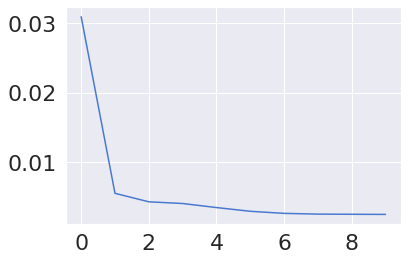

In [ ]:
plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

8/8 [==============================] - 1s 31ms/step - loss: 0.0000e+00


,MAE,MSE,MAPE
Train,545.16,"719,288.32",8.28
Test,528.84,"574,244.60",6.09


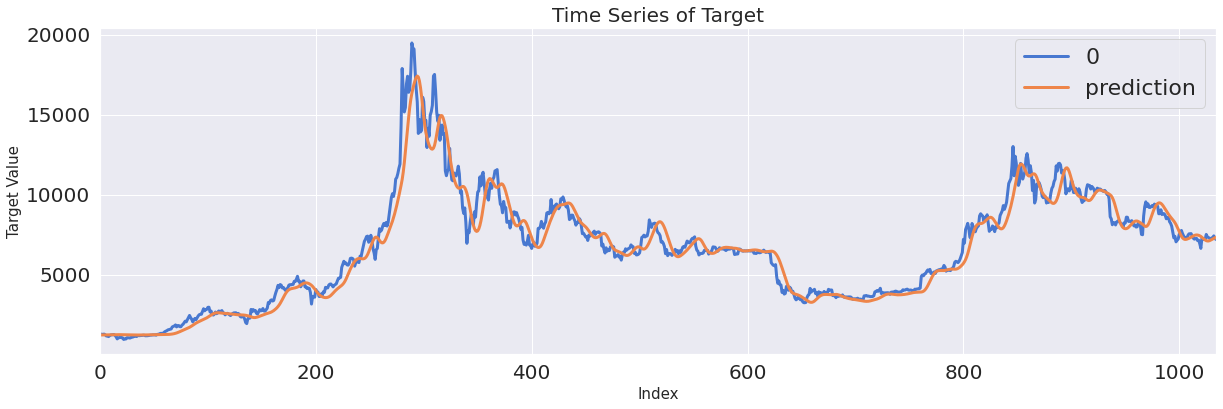

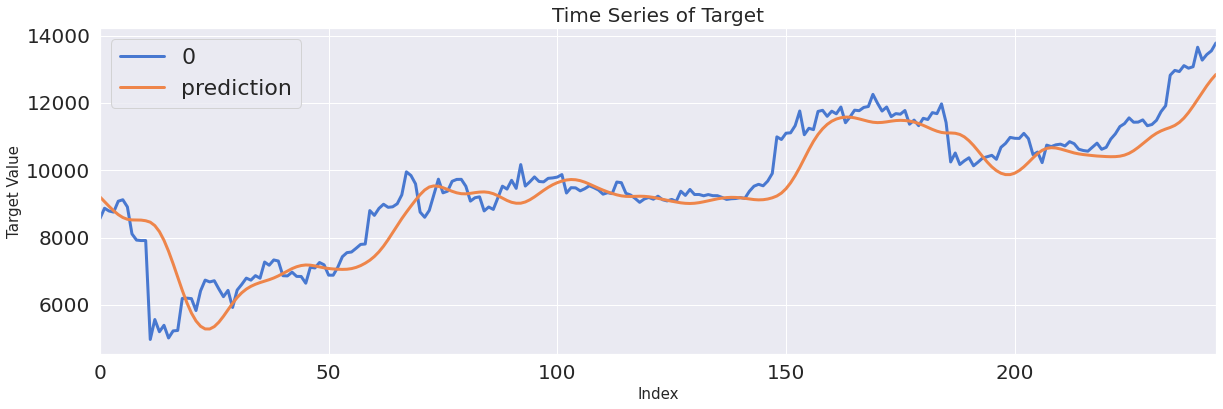

In [ ]:
# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_LSTM)

#### GRU 분석

In [ ]:
# Parameters
criteria = '2020-01-01'
scaler = preprocessing.MinMaxScaler()
sequence = 60
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = raw_all.loc[raw_all.index < criteria,:]
test = raw_all.loc[raw_all.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)

Train_size: (1095, 1) Test_size: (305, 1)


In [ ]:
## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

X_train: (1035, 60, 1) Y_train: (1035, 1)
X_test: (245, 60, 1) Y_test: (245, 1)


In [ ]:
## GRU 모델링
model = Sequential()

model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 

model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 

model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 

model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 60, 128)           50304     
_________________________________________________________________
dropout_16 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 60, 256)           296448    
_________________________________________________________________
dropout_17 (Dropout)         (None, 60, 256)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 60, 128)           148224    
_________________________________________________________________
dropout_18 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 64)               

In [ ]:
# 학습
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)


Epoch 1/10
33/33 [==============================] - 16s 395ms/step - loss: 0.0371
Epoch 2/10
33/33 [==============================] - 13s 397ms/step - loss: 0.0025
Epoch 3/10
33/33 [==============================] - 13s 396ms/step - loss: 0.0018
Epoch 4/10
33/33 [==============================] - 13s 395ms/step - loss: 0.0015
Epoch 5/10
33/33 [==============================] - 13s 399ms/step - loss: 0.0014
Epoch 6/10
33/33 [==============================] - 13s 397ms/step - loss: 0.0012
Epoch 7/10
33/33 [==============================] - 13s 396ms/step - loss: 9.3043e-04
Epoch 8/10
33/33 [==============================] - 13s 392ms/step - loss: 8.0346e-04
Epoch 9/10
33/33 [==============================] - 13s 389ms/step - loss: 9.9370e-04
Epoch 10/10
33/33 [==============================] - 13s 400ms/step - loss: 8.5624e-04


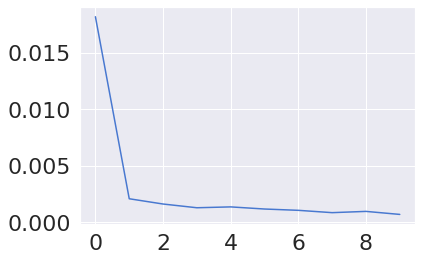

In [ ]:
plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

8/8 [==============================] - 1s 33ms/step - loss: 0.0000e+00


,MAE,MSE,MAPE
Train,537.33,"465,576.21",9.46
Test,648.66,"522,832.17",6.93


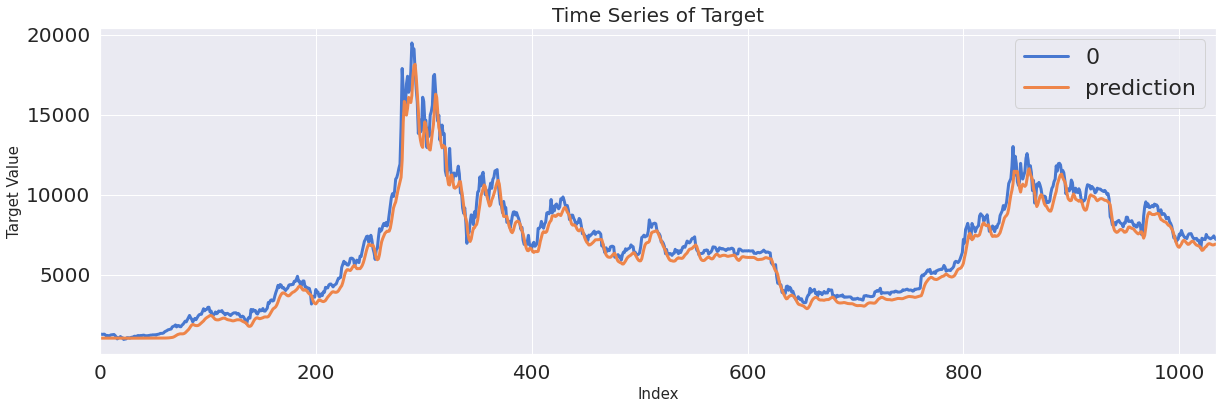

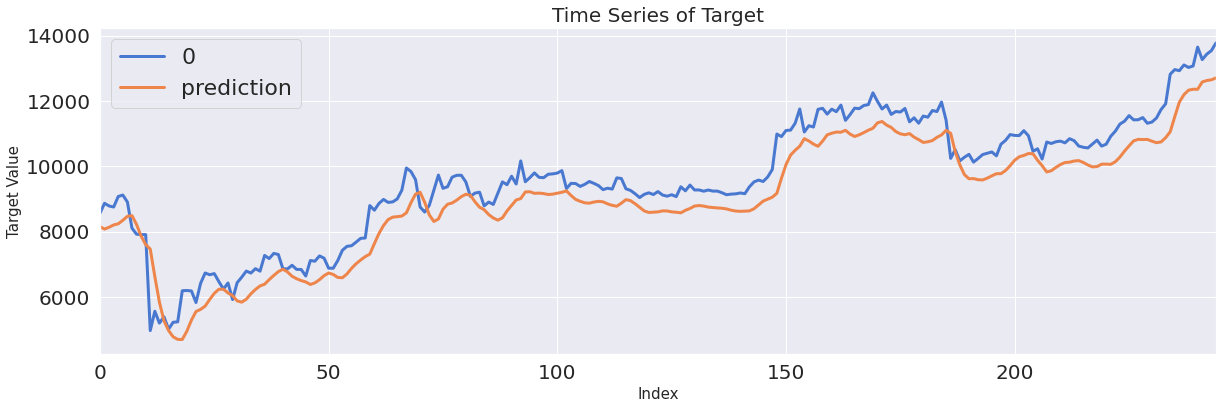

In [ ]:
# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)